# Examen Modèles Linéaires
**Authors :** *Paul Strang, Lucas Robinet*


## Exercice 1
Un medecin souhaite mettre en lien l'impact de differentes variables mesurees sur
un `score` qu'il estime pour quantifier le niveau d'une maladie. Les donnees sont
sauvegardees dans le fichier`obs2021_1.csv`. Idealement, il souhaiterait que seul un
sous ensemble de ces variables permette d'expliquer le score.

In [114]:
# Standard libraries
from typing import Tuple

# Third-party libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import f_classif
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve

<div class="alert alert-block alert-warning">
    Avant de commencer à répondre aux questions, il semble important de réaliser une première analyse exploratoire du jeu de données pour essayer de mieux le comprendre. <b>Dans un premier temps</b>, avant de répondre aux questions nous allons <b>extraire</b> différentes informations de notre fichier csv
    </div>

In [2]:
dataframe = pd.read_csv("./obs2021_1.csv", sep=';')
dataframe.head(10)

,var01,var02,var03,var04,var05,var06,var07,var08,var09,var10,var11,var12,var13,var14,var15,var16,var17,var18,score
0,11.6,6.4,4.3,7.2,14.4,19.26,39.32,50.00,13.040000,0.20,0.0440,-1.578984,2.209,9.02,0.26,94.285053,3.56,16.91,6
1,15.5,10.5,4.9,6.9,13.7,8.57,36.78,22.57,18.713333,0.51,0.8501,-2.497499,0.339,22.43,0.10,86.766527,7.06,-3.47,6
2,15.3,6.5,4.2,6.4,13.6,13.48,25.90,8.25,8.246667,0.27,0.9629,-3.638758,0.339,17.94,0.13,107.336147,3.20,10.05,10
3,13.4,7.7,4.1,5.8,14.2,15.23,44.36,11.09,11.093333,0.67,-0.2756,-6.273760,1.611,11.38,0.20,136.516384,4.33,-3.62,18
4,16.0,5.2,3.2,5.7,12.8,8.37,19.62,7.44,6.386667,0.24,-0.6928,-2.096575,0.659,8.56,0.27,88.774469,4.57,1.56,7
5,12.1,6.1,4.0,6.4,14.8,18.40,34.34,8.52,8.520000,0.79,0.6982,-3.404306,0.954,9.18,0.25,97.840929,2.37,13.26,12
6,7.3,5.3,4.1,6.3,13.5,14.63,35.57,14.32,14.320000,0.35,0.9224,-2.461047,1.536,9.14,0.25,123.570435,6.44,-0.84,8
7,14.4,8.1,6.2,6.9,13.2,16.11,26.43,6.75,6.593333,0.91,0.7559,-0.549435,0.960,7.65,0.30,83.706014,3.36,14.23,8
8,10.8,7.1,4.1,7.9,14.2,9.67,32.16,15.15,14.113333,0.24,0.2858,-3.092822,0.779,9.57,0.24,72.131613,4.34,3.77,10
9,14.6,4.7,3.5,5.8,13.6,8.57,21.56,8.72,8.006667,0.49,-0.0057,-3.248667,1.591,7.45,0.31,3.483233,3.76,4.32,5


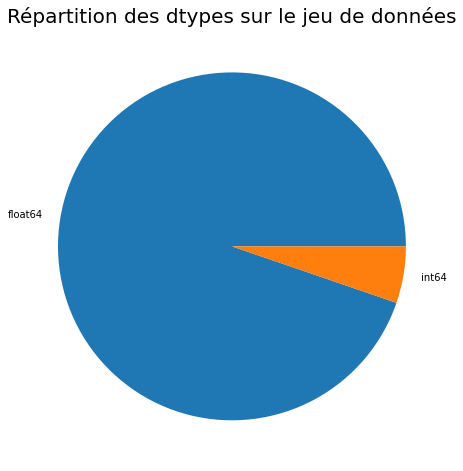

In [3]:
plt.figure(figsize=(12, 8))
dataframe.dtypes.value_counts().plot.pie()
plt.title("Répartition des dtypes sur le jeu de données", fontsize=20)
plt.axis('off')
plt.show()

**Le jeu de données fait intervenir 18 variables quantitatives (var*i*) ainsi qu'une variable qualitative (score)**

In [4]:
dataframe.isna().value_counts() # on vérifie qu'il n'y ait aucune valeurs manquantes

var01  var02  var03  var04  var05  var06  var07  var08  var09  var10  var11  var12  var13  var14  var15  var16  var17  var18  score
False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False    66
dtype: int64

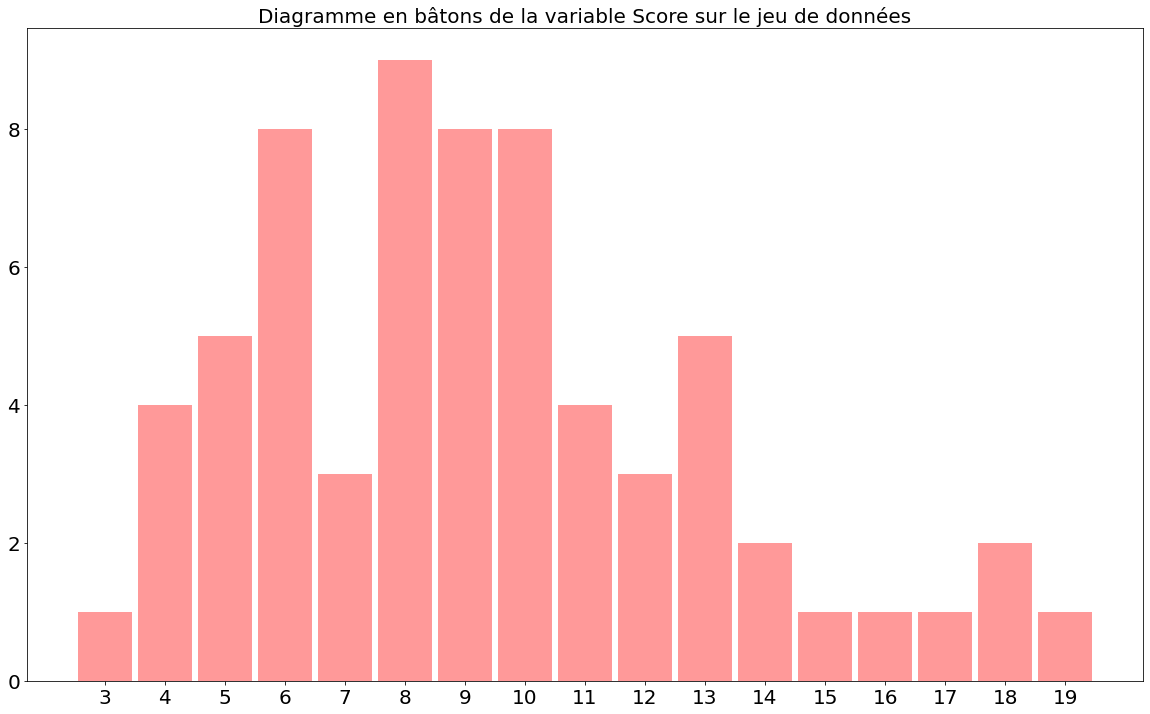

In [5]:
unique_x, counts_x = np.unique(dataframe['score'], return_counts=True)
plt.figure(figsize=(20, 12))
plt.bar(unique_x, counts_x, width=0.9, color='red', alpha=0.4)
plt.title("Diagramme en bâtons de la variable Score sur le jeu de données", fontsize=20)
plt.xticks(unique_x, fontsize=20)
plt.yticks(fontsize=20)
plt.show()

Une donnée importante est également la matrice de corrélation de notre jeu de données calibrée sur le coefficient de **Pearson**.

In [6]:
corr_matrix = dataframe.corr()

In [7]:
corr_matrix["score"].sort_values(ascending=False)

score    1.000000
var16    0.847045
var01    0.477035
var11    0.162619
var15    0.095162
var13    0.085404
var10    0.057784
var03    0.050145
var02    0.038244
var14    0.030812
var04    0.020371
var18   -0.014897
var09   -0.057870
var07   -0.067441
var05   -0.149631
var08   -0.154726
var06   -0.174501
var17   -0.219649
var12   -0.410224
Name: score, dtype: float64

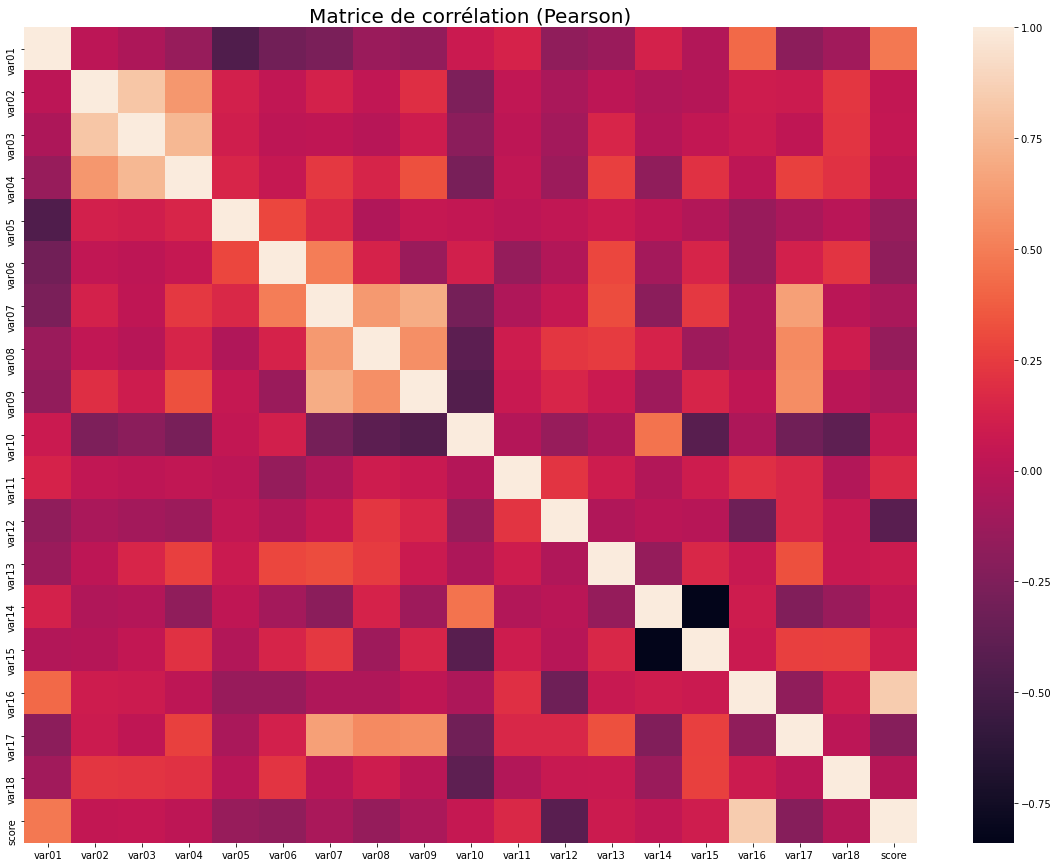

In [8]:
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix)
plt.title("Matrice de corrélation (Pearson)", fontsize=20)
plt.show()

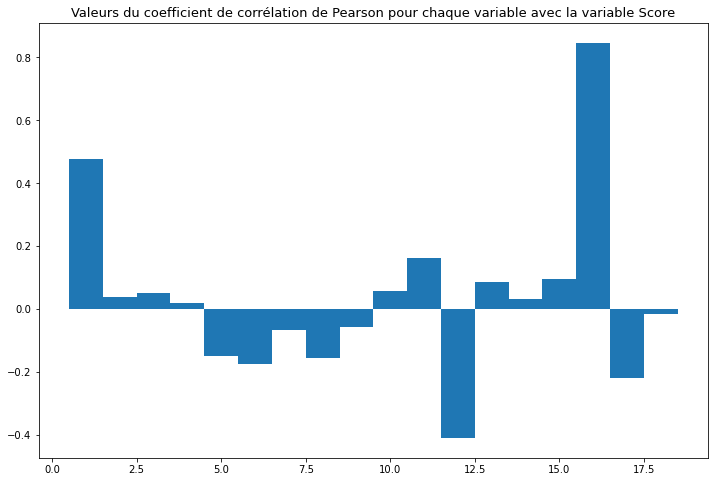

In [9]:
plt.figure(figsize=(12, 8))
plt.bar([i for i in range(1, 19)], corr_matrix["score"].values[:-1], width=1)
plt.title("Valeurs du coefficient de corrélation de Pearson pour chaque variable avec la variable Score", fontsize=13)
plt.show()

<div class="alert alert-block alert-warning">
    <b><u>N.B :</b></u> Sur cette brève introduction, le but n'est pas d'analyser le jeu de données en profondeur avec des explications précises et détaillées mais plutôt de permettre une première compréhension et aussi une aide tout au long des <i>Travaux Pratiques.</i>
</div>

Maintenant, commençons

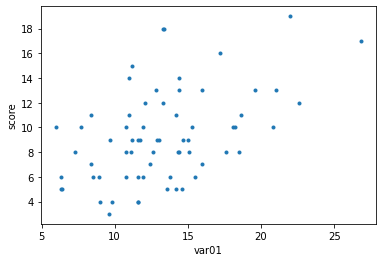

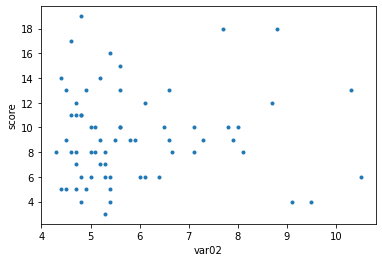

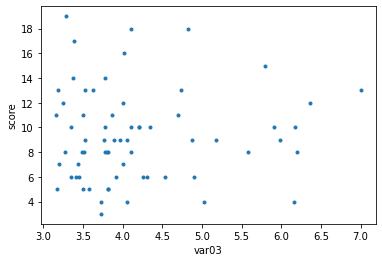

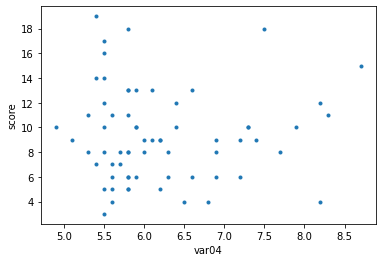

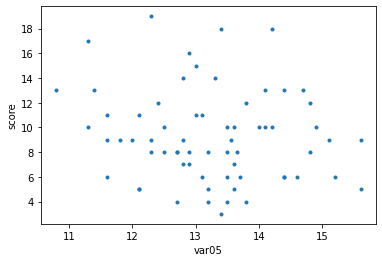

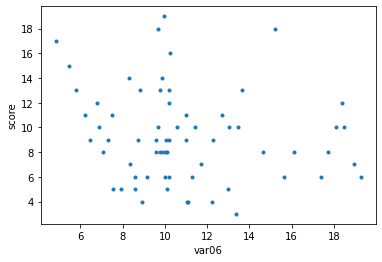

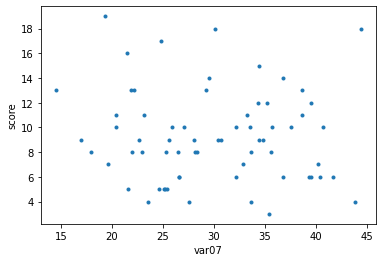

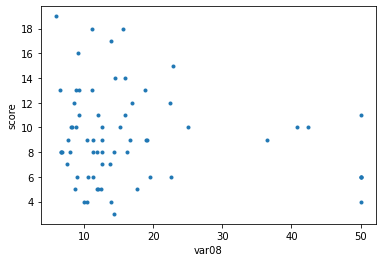

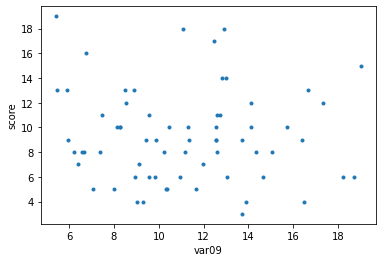

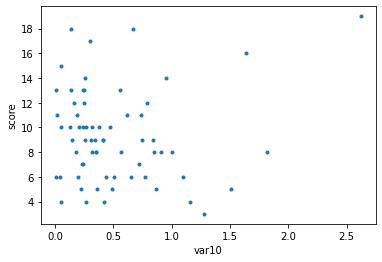

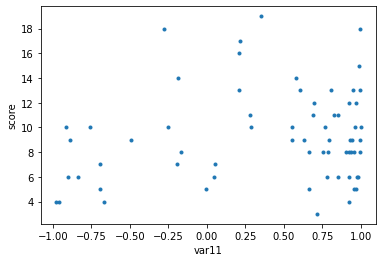

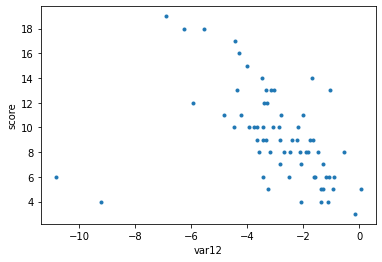

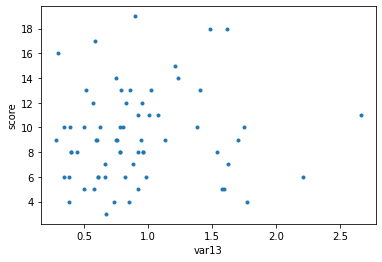

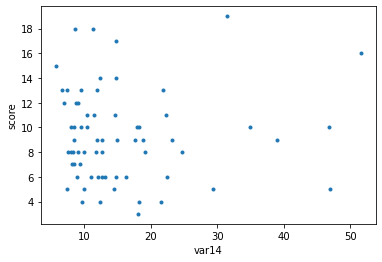

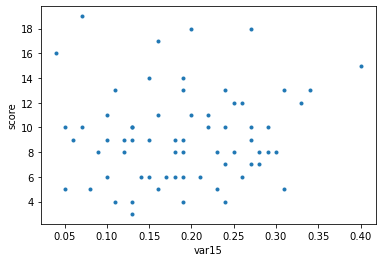

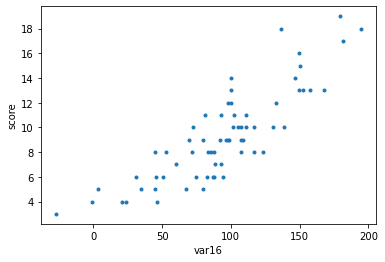

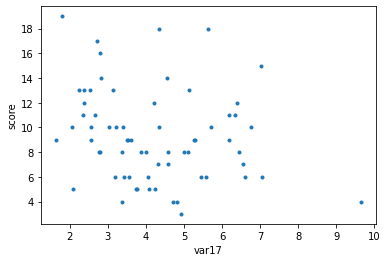

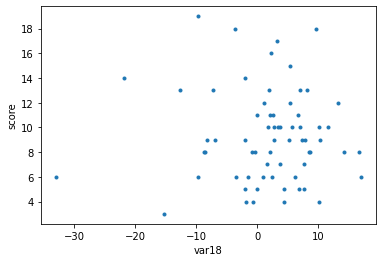

In [10]:
listColNames=list(dataframe.columns)


XY=dataframe.values
ColNb_Y=listColNames.index('score')


Y=XY[:,ColNb_Y].reshape((XY.shape[0],1))   #reshape is to make sure that Y is a column vector
X = np.delete(XY, ColNb_Y, 1)

listColNames.pop(ColNb_Y)     #to make it contains the column names of X only


for Col in range(len(listColNames)):
    plt.plot(X[:,Col],Y[:],'.')
    plt.xlabel(listColNames[Col])
    plt.ylabel('score')
    plt.show()


### <span style="color:blue">QUESTION 1.1 :</span> 

Observez les donnees unes par unes. 
Est-ce que vous identifiez visuellement des liens entre
certaines variables et la variable `score`. Si oui, lesquels ?

<div class="alert alert-block alert-success">
    <b>Réponse 1.1:</b> A la vue de ces graphes, la variable <b> score </b> semble avoir une relation linéaire croissante avec  <b> var16 </b> et une relation linéaire décroissante avec <b> var12 </b>
</div>

### <span style="color:blue">QUESTION 1.2 :</span> 

On se demande si il est possible de predire le niveau de `score` à partir d'une seule des variables `var02`, `var09` ou `var16`.

#### <span style="color:blue">QUESTION 1.2.1 :</span> 

Effectuez une regression lineaire simple entre 'score' et chacune de ces variables.  Toutes les donnees seront utilisees pour l'apprentissage. Evaluez alors la qualité des predictions, sur toutes les donnees, l'aide de la moyenne de l'erreur de prediction sur toutes les donnees, l'aide de la moyenne de l'erreur de prediction au
carre (MSE). Quel est le risque potentiel en utilisant cette stratégie de validation de l'apprentissage ?

In [11]:
def linear_regression(X: np.ndarray, Y: np.ndarray, idx: int) -> None:
    lr = LinearRegression()
    lr.fit(X[:, idx-1][:, np.newaxis], Y)
    y_pred = lr.predict(X[:, idx-1][:, np.newaxis])
    fig = plt.figure(figsize=(12, 10))
    plt.plot(X[:, idx-1], Y, 'r.')
    plt.plot(X[:, idx-1], y_pred, 'b-')
    plt.legend(('Data', 'Linear Fit'), loc='lower right')
    plt.title('Linear regression')
    plt.xlabel(f"var{idx}")
    plt.ylabel("Score")
    plt.show()
    print(f"La droite de régression trouvée pour var{idx} a pour équation : {float(lr.coef_):.3f}x + {float(lr.intercept_):.3f}")
    print(f"MAE pour le modèle = {mean_absolute_error(Y, y_pred):.3f}")
    print(f"MSE pour le modèle = {mean_squared_error(Y, y_pred):.3f}")

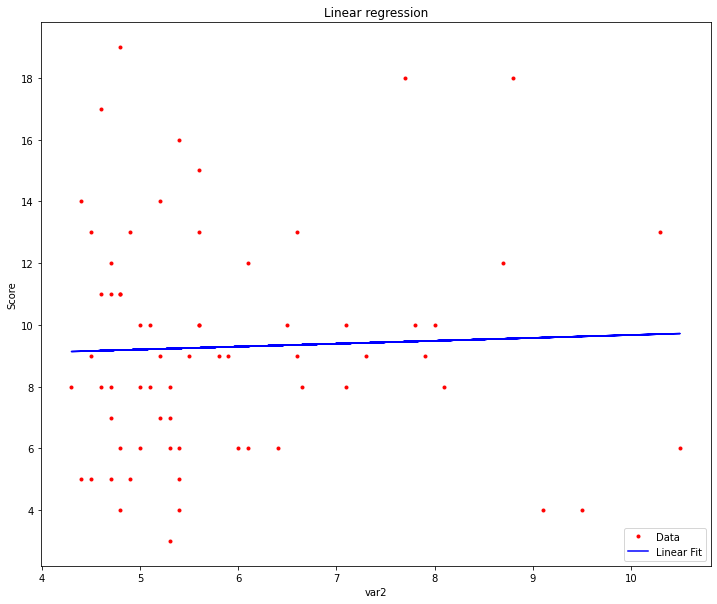

La droite de régression trouvée pour var2 a pour équation : 0.094x + 8.733
MAE pour le modèle = 2.901
MSE pour le modèle = 13.549


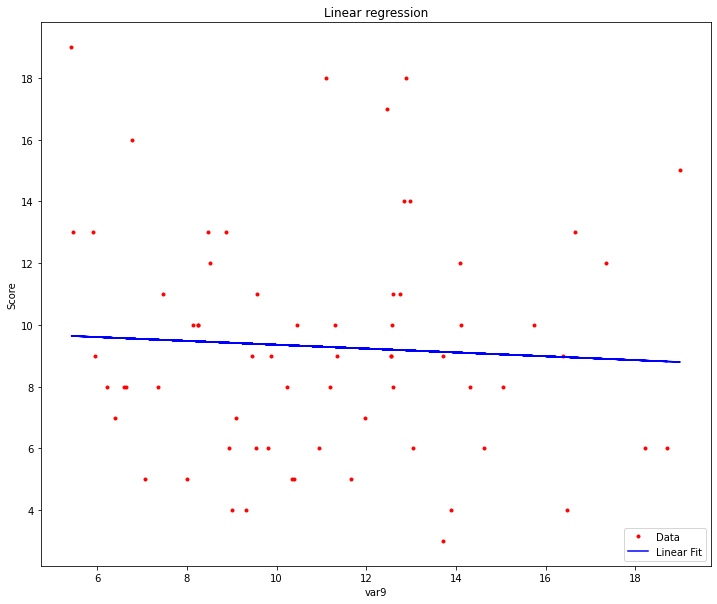

La droite de régression trouvée pour var9 a pour équation : -0.062x + 9.978
MAE pour le modèle = 2.906
MSE pour le modèle = 13.523


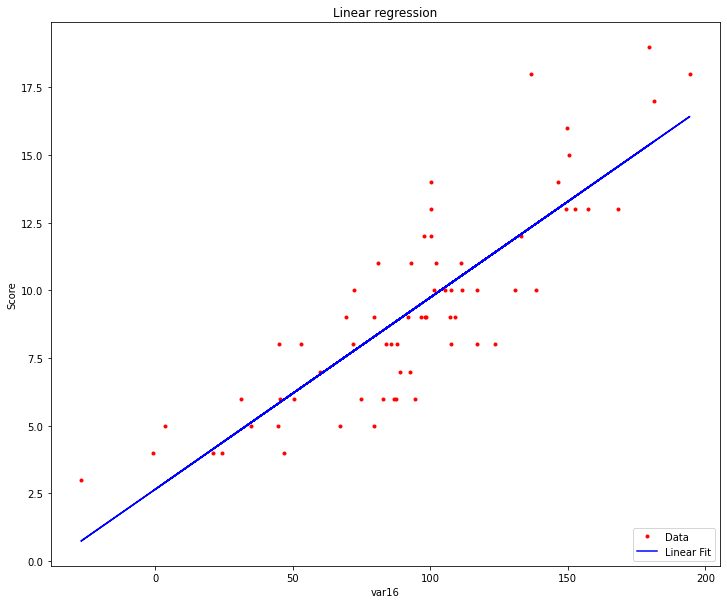

La droite de régression trouvée pour var16 a pour équation : 0.071x + 2.651
MAE pour le modèle = 1.563
MSE pour le modèle = 3.833


In [12]:
indexes: Tuple[int] = (2, 9, 16)
    
for idx in indexes:
    linear_regression(X, Y, idx)

<div class="alert alert-block alert-success">
    <b> Réponse 1.2.1: </b>Quand nous évaluons la performance de notre modèle sur le jeu d'entraînements, nous évaluons l'erreur quadratique moyenne.

$\mathrm{MSE}_{\text {train}}=\frac{1}{m} \sum_{i}\left(\hat{\boldsymbol{y}}^{(\text {train })}-\boldsymbol{y}^{(\text {train })}\right)_{i}^{2}            (1) $ où $ \hat{\boldsymbol{y}} $ est l'estimation de notre valeur par notre modèle. <br> <br>

On dira donc qu'un modèle est plus performant qu'une autre s'il a une erreur quadratique moyenne inférieure.

En considérant cela, notre modèle est, <b>peut-être,</b> sujet au phénomène de <b> sur-apprentissage </b>. Lorsque nous utiliserons ce modèle sur de nouvelles données réelles, il risque de sous-performer car trop attaché à ses données d'entraînements. En effet, notre estimateur de performance risque d'avoir une <b> variance forte </b>. Nous pouvons donc nous attendre à ce que l'estimation que nous calculons à partir des données varie lorsque nous rééchantillonnons indépendamment l'ensemble de données. <br> <br>
    

Il serait donc préférable de créer deux sous jeux de données, un d'entraînement et un de validation et <b>d'estimer la performance du modèle avec l'erreur quadratique moyenne sur le jeu de validation </b> <br> <br>

$\mathrm{MSE}_{\text {val}}=\frac{1}{m} \sum_{i}\left(\hat{\boldsymbol{y}}^{(\text {val})}-\boldsymbol{y}^{(\text {val })}\right)_{i}^{2}  (2) $
</div>

#### <span style="color:blue">QUESTION 1.2.2 :</span> 

Evaluez a quel point les predictions sont stables a l'aide d'une methode de validation croisee de type 5-folds.

In [13]:
def display_scores(scores: np.ndarray) -> None:
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [14]:
def using_5folds(X: np.ndarray, Y: np.ndarray, idx: int) -> None:
    lr = LinearRegression()
    X_selected = X[:, idx-1][:, np.newaxis]
    scores = -cross_val_score(lr, X_selected, Y, scoring="neg_mean_squared_error", cv=5) 
    #take care of the 5 trainings and splits
    display_scores(scores)

In [15]:
for idx in indexes:
    print(f"\n       FOR var{idx} :\n")
    using_5folds(X, Y, idx)


       FOR var2 :

Scores: [11.07113497 21.51317623 12.42227464 18.78096436 10.91974038]
Mean: 14.941458117496378
Standard deviation: 4.3687340818516125

       FOR var9 :

Scores: [11.47517581 20.40593564 11.51041288 16.88728663 10.98554691]
Mean: 14.25287157588833
Standard deviation: 3.7606495179252866

       FOR var16 :

Scores: [7.28382143 5.22016069 2.3907413  2.25222998 3.45246688]
Mean: 4.119884056119778
Standard deviation: 1.9049735165783088


<div class="alert alert-block alert-success">
    <b>Réponse 1.2.2: </b> En effectuant un 5-Fold, on prédit la MSE de chaque modèle avec plus de robustesse, ainsi que la variabilité des prédictions. <br> <br>
    
On observe donc que <b> var16 </b> permet de faire le modèle le plus stable -<i>avec les plus faibles écarts entre chaque folds</i>- (écart type ~ 1.9), le plus performant en moyenne (moyenne ~ 4.1) et sur les 5 validations séparemment et est donc le plus fiable.

#### <span style="color:blue">QUESTION 1.2.3 :</span> 

Peut-on enfin dire si on observe une relation significative entre `score`
et (indépendament) `var02`, `var09` ou bien `var16`. On peut le valider a l'aide d'un test d'hypothese dont on decrira la procedure.

<div class="alert alert-block alert-warning">
    <b> Une première ébauche de réponse pourrait être la suivante : </b>
    <ol>
     <li>On semble obtenir une régression avec une erreur quadratique moyenne correcte pour le modèle entraîné avec <b> var16 </b> sur l'ensemble des folds de validation. A l'inverse, les modèles entraînés respectivement sur<b> var09 </b> ainsi que <b> var02 </b> montrent des performances bien en-deça avec des instabilités liées aux données d'entraînements (modèles plus ou moins performants selon les folds) ce qui implique un problème de <b> généralisation. </b> </li>
 <li>D'après l'étude préliminaire des coefficients de corrélation de Pearson, on peut en déduire qu'il peut exister une relation linéaire entre la variable<b> score </b>et la variable <b> var16</b> mais pas avec <b> var09 </b> ou bien <b> var02 </b> <br> <br>
     <u> Rappels :</u> <br> <br>
     $\rho(score, var16) = 0.84$ <br> <br>
     $\rho(score, var09) = -0.058$ <br> <br>
     $\rho(score, var02) = 0.038$
        
</li>
</ol>
    </div>

##### En ayant ces éléments en tête, validons cette idée avec un test d'hypothèse dont la procédure est décrite dans la cellule ci-dessous

<div class="alert alert-block alert-warning">
    <b> PROCEDURE DE TEST : </b> <br> <br>
    On sait que si l'on a une relation significative entre <b> score </b> et une variable, cela signifique que, dans le cas de l'équation $ y = \beta_1x + \beta_0 $, on a $ \beta_1 = 0 $.
    Ainsi, il faut regrouper, pour chaque valeur de <b> score </b> (variable qualitative), les valeurs quantitatives de <b> var.. </b> correspondantes. S'il n'existe pas de relation, alors pour chaque valeur de score (allant de 3 à 19), la moyenne des valeurs de la variable quantitative devrait ne pas être trop proches. <br> <br>
Soit $i \in \{3, 4, ..., 19\} $ <br> <br>
On note $\mu_{i} $ la moyenne de la variable quantitative associée à la valeur de score $i$.
    
<b>Le test d'hypothèse est le suivant :</b> <br> <br>
    
$ (H_0): \mu_{i} = \mu_{j}$ <br> $\forall i, j \in \{3, 4, ..., 19\}, i \neq j$ <br> <br>
    
    
    
$ (H_1): \exists i, j \in \{3, ..., 19\}, i \neq j $ <br> 
$ \mu_{i} \neq \mu_{j}$
    </div>
   

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths

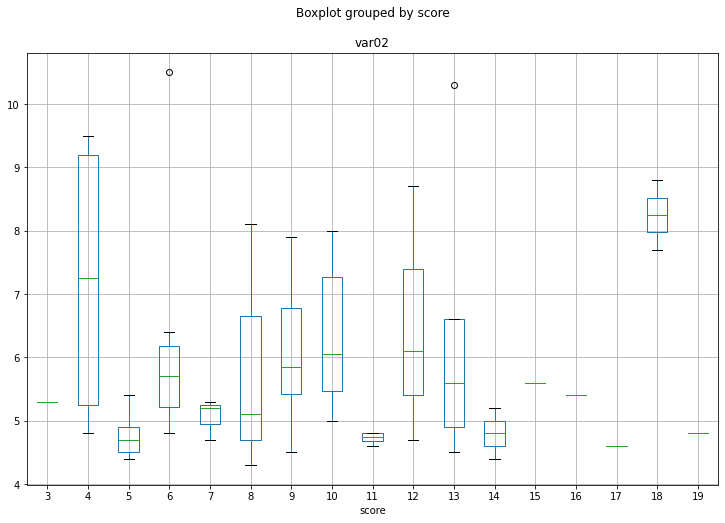

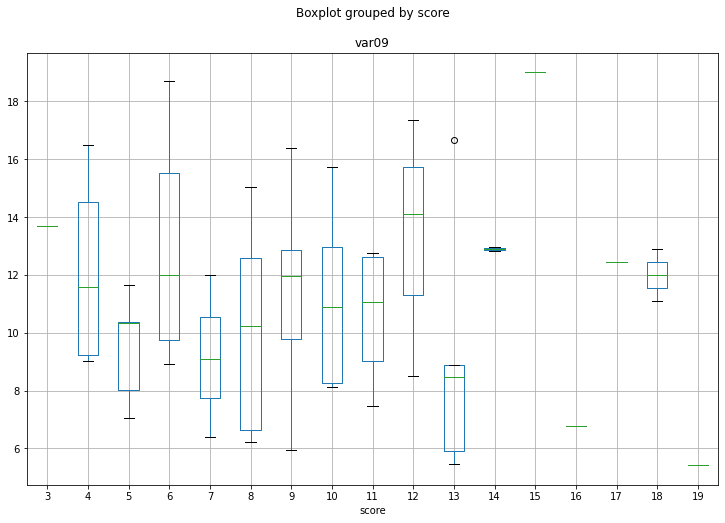

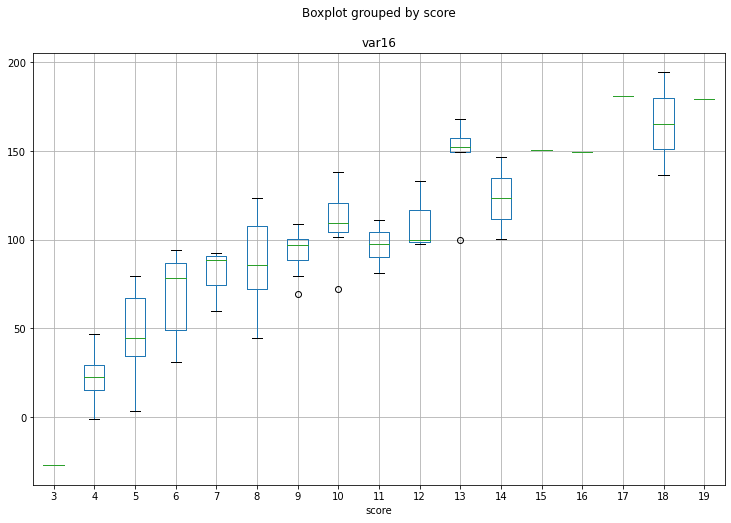

In [16]:
for i in ('02', '09', '16'):
    dataframe.boxplot(f'var{i}', by='score', figsize=(12,8))
plt.show()

<div class="alert alert-block alert-warning">
    En regardant les différents boxplots, on constate que les distributions de <b> var02 </b>et <b>var09</b> selon le score sont un peu chaotiques et dispersés avec des difficultés à extraire une vraie tendance. <br> <br>
    En revanche, pour la distribution de <b>var16</b> en fonction des différents scores, une sérieuse tendance positive semble se dégager, nous souhaitons valider cela avec le test énoncé ci-dessus
    </div>

In [17]:
def anova(X: np.ndarray, Y: np.ndarray, idx: int) -> Tuple[np.ndarray]:
    X_selected = X[:, idx-1][:, np.newaxis]
    return f_classif(X_selected, Y.reshape(-1))

In [18]:
alpha = 0.05
print("REPORT SUMMARY - Test on features of interest")
for idx in indexes:
    print(f"\nLet's perform Anova on var{idx} :\n")
    f_statistic, p_values = anova(X, Y, idx)
    print(f"F-statistic = {float(f_statistic)}")
    print(f"p-value = {float(p_values)}")
    if float(p_values) <= alpha:
        print(f"L'hypothèse de l'égalité des moyennes, et donc de l'absence de relations entre var{idx} et score, est rejetée")
    else:
        print(f"L'hypothèse de l'égalité des moyennes, et donc de l'absence de relations entre var{idx} et score, est acceptée")

REPORT SUMMARY - Test on features of interest

Let's perform Anova on var2 :

F-statistic = 1.2462495785821543
p-value = 0.2693325605423099
L'hypothèse de l'égalité des moyennes, et donc de l'absence de relations entre var2 et score, est acceptée

Let's perform Anova on var9 :

F-statistic = 1.3329342000282063
p-value = 0.21616549677841956
L'hypothèse de l'égalité des moyennes, et donc de l'absence de relations entre var9 et score, est acceptée

Let's perform Anova on var16 :

F-statistic = 12.09819506167301
p-value = 6.310869027221378e-12
L'hypothèse de l'égalité des moyennes, et donc de l'absence de relations entre var16 et score, est rejetée


<div class="alert alert-block alert-success">
    <b>Réponse 1.2.3: </b> Au vu des résultats, on peut conclure que <b> var02</b> et <b>var09</b> n'ont pas une relation significative avec <b> score </b>, mais que <b>var16</b> a une relation significative avec <b> score</b> conformément à ce que nous avancions tout à l'heure.
    </div>

### <span style="color:blue">QUESTION 1.3 :</span> 

On s'interesse maintenant au lien entre la variable `score` et `var12`.
On peut remarquer que ces donnees contiennent deux valeurs aberrantes.

#### <span style="color:blue">QUESTION 1.3.1 :</span> 

Definissez une procedure pour detecter automatiquement deux donnees aberrantes dans un jeu de donnees.

<div class="alert alert-block alert-warning">
Pour cette question nous avons choisi de présenter deux méthodes :
    <ol>
        <li> La méthode classique reposant sur le calcul des <b>profils résiduels</b> et la <b>distance de Cook</b> que nous avons vu aux cours des BE. </li>
        <li> Une méthode <b>d'apprentissage non-supervisée</b> basée sur l'algorithme <b> IsolationForest </b>.
</div>

### Méthode 1 :

In [24]:
var12 = X[:, 11]

#### Réalisons le calcul des profils résiduels

In [25]:
def profil_residuel(x: np.ndarray, y: np.ndarray, i: int) -> np.ndarray:
    lr = LinearRegression()
    xx = np.concatenate((x[:i], x[i+1:]), axis=0)
    yy = np.concatenate((y[:i], y[i+1:]), axis=0)
    lr.fit(xx[:, np.newaxis], yy)
    y_pred = lr.predict(x[:, np.newaxis])
    return (y_pred - y)**2

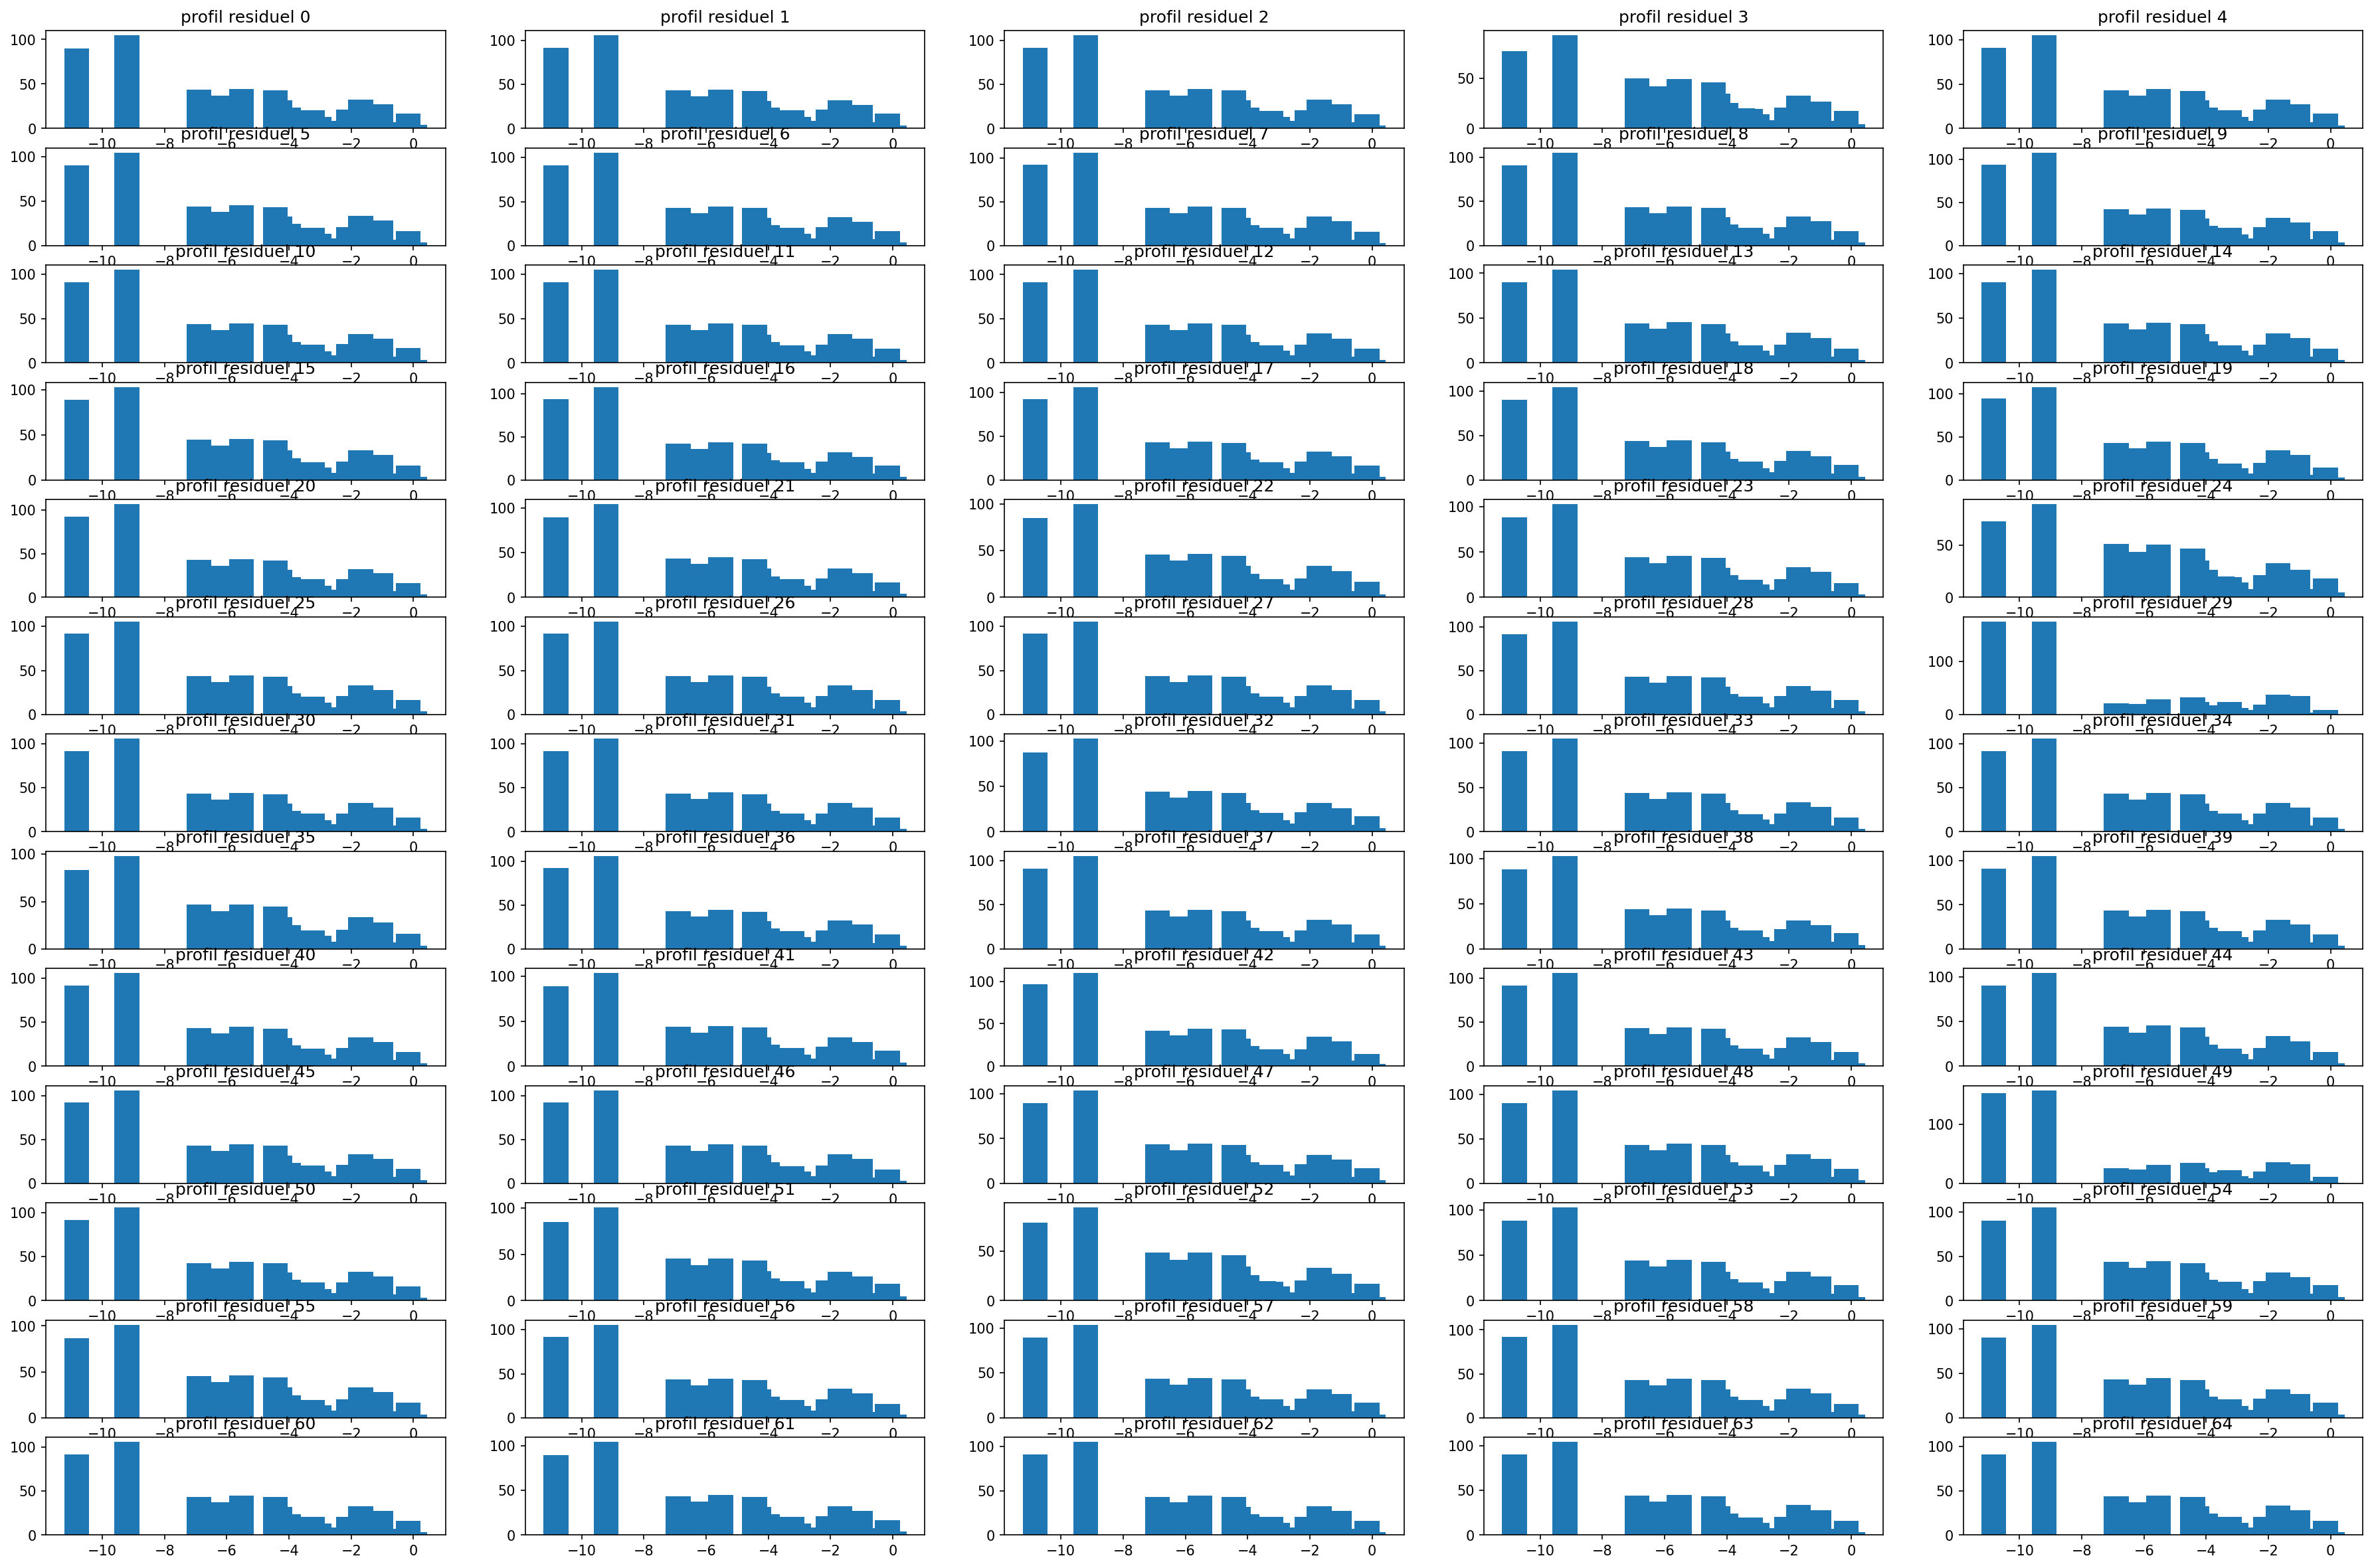

In [26]:
fig, ax = plt.subplots(len(var12)//5, 5, figsize=(30,20), dpi=150)
for i in range(len(var12)-1):
    ax[i//5, i%5].bar(var12, profil_residuel(var12, Y.reshape(-1), i))
    ax[i//5, i%5].set_title('profil residuel {}'.format(i))
plt.show()

Le profil résiduel de la donnée aberrante est toujours plus grand que les autres, en particulier lorsqu'on ôte la donnée de la base d'apprentissage. Les données aberrantes semblent être aux index **29** et **49**


Essayons maintenant la distance de **Cook**

In [27]:
def s2(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    n = len(y_true)
    SSE = np.sum((y_true - y_pred)**2)
    return SSE / (n-1)

In [28]:
def cook(x: np.ndarray, y: np.ndarray, i: int) -> np.ndarray:
    lr = LinearRegression()
    xx = np.concatenate((x[:i], x[i+1:]), axis=0)
    yy = np.concatenate((y[:i], y[i+1:]), axis=0)
    lr.fit(xx[:, np.newaxis], yy)
    
    lr_tot = LinearRegression()
    lr_tot.fit(x[:, np.newaxis], y)
    y_tot = lr_tot.predict(x[:, np.newaxis])
    
    y_pred = lr.predict(x[:, np.newaxis])
    SSD = np.sum((y_pred - y_tot)**2)
    s_2 = s2(y_tot, y)
    
    return SSD / (2*s_2)

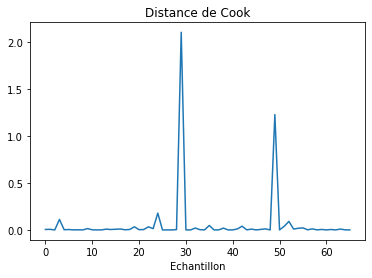

In [29]:
cook_ = [cook(var12, Y, i) for i in range(len(var12))]
plt.plot(cook_)
plt.title('Distance de Cook')
plt.xlabel('Echantillon')
plt.show()

In [35]:
np.where(np.array(cook_) > 1.)

(array([29, 49]),)

<div class="alert alert-block alert-warning">
    Ainsi, avec ces méthodes, on trouve les deux données aberrantes qui sont localisées aux index <b>29</b> et <b>49</b>. <br> <br>
    
Le code ci-dessus est le code identique à celui du <b>TP. 1.</b>
    
Si l'on connait le pourcentage de données aberrantes, comme c'est le cas ici où on sait que <b> deux données </b> sur 66 (~ 3%) sont <i> contaminées </i>, on peut également utiliser une méthode de détection d'anomalies : <b>IsolationForest. </b> <br> <br>
    
On se propose ici de mener à bien cette méthode.
</div>

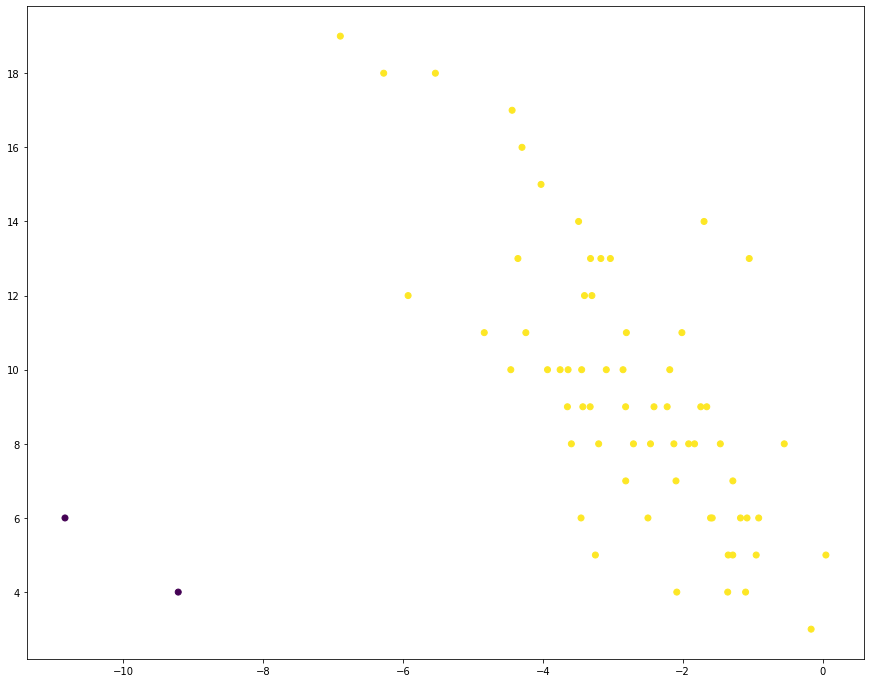

In [48]:
model = IsolationForest(contamination=0.03)
model.fit(np.concatenate([var12[:, np.newaxis], Y], axis=1))
plt.figure(figsize=(15, 12))
predicted = model.predict(np.concatenate([var12[:, np.newaxis], Y], axis=1))
plt.scatter(var12, Y, c=predicted)
plt.show()

In [50]:
np.where(predicted == -1)

(array([29, 49]),)

<div class="alert alert-block alert-success">
    <b>Réponse 1.3.1</b>: Les données aberrantes sont celles aux indices <b> 29</b> et <b> 49</b>.
    </div>

#### <span style="color:blue">QUESTION 1.3.2 :</span> 

Nous supprimerons dans la suite de cet exercice les deux observations qui sont aberrantes sur
la variable `var12`. Comment auriez-vous traite ces observations si vous aviez absolument
voulu preserver l'information qu'elles contiennent dans les autres variables ?

In [51]:
X = X[predicted == 1]
Y = Y[predicted == 1]

print(X.shape)
print(Y.shape)

(64, 18)
(64, 1)


<div class="alert alert-block alert-success">
    <b>Réponse 1.3.2</b>: Ici on a bien retiré les deux données aberrantes de var12 de l'ensemble du jeu de données. <br> <br>
    
Si nous voulions conserver ces deux outliers et l'information qu'elles contiennent dans les autres variables, il faudrait s'assurer que leurs éloignements ne biaisent pas trop le modèle en leur faveur. En effet, le critère des moindres carrées est très sensible à ces outliers.
    Pour les conserver, il aurait donc fallu utiliser un critère de minimisation différent, et ainsi délaisser la <b>Mean Squared Error</b> au profit de la <b>Mean Absolute Error</b> (en norme $ \lVert . \rVert_1 $
) qui a pour avantage de ne pas donner trop de poids aux outliers. <br> <br>

### <span style="color:blue">QUESTION 1.4 :</span> 

Une fois les deux observations aberrantes de `var12` supprimees, on souhaite selectionner les
variables de`X` qui permettent de prédire au mieux 'score' a l'aide de la
regression multiple regularisee.

#### <span style="color:blue">QUESTION 1.4.1 :</span> 

Quelle strategie vous semble la plus appropriee pour selectionner les variables les plus
pertinentes ? Quel pretraitement allez-vous de meme effectuer sur les donnees.

<div class="alert alert-block alert-success">
    <b>Réponse 1.4.1: </b> Pour sélectionner les variables les plus pertinentes, la stratégie la plus appropriée semble être la <b>Régression linéaire de Lasso</b>, qui a l'avantage d'attribuer la valeur zéro aux coefficients sur les features les moins significatives. <br> <br>
    $$
\widehat{\beta}_{L A S S O}=\underset{\beta \in \mathbb{R}^{p+1}}{\arg \min }\left(\sum_{i=1}^{n}\left(Y_{i}-\sum_{j=0}^{p} X_{i}^{(j)} \beta_{j}\right)^{2}+\lambda \sum_{j=1}^{p}\left|\beta_{j}\right|\right)
$$
    
Il est nécessaire de prétraiter les données en les standardisant pour éviter tout poids fictif liés aux effets d'échelles sur des variables non significatives.

In [54]:
X_scaled = scale(X)

#### <span style="color:blue">QUESTION 1.4.2 :</span> 

Effectuez la procedure de selection des variables optimales en parametrant a la main le poids
entre la qualite de prediction et le niveau de regularisation.

In [81]:
X_train_scaled, X_test_scaled, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.3, random_state=42)

alpha = 0.2
lasso_regressor = Lasso(alpha=alpha)
lasso_regressor.fit(X_train_scaled, Y_train)

y_pred_lasso = lasso_regressor.predict(X_test_scaled)
mse_score_lasso = mean_squared_error(Y_test, y_pred_lasso)
print(f"Pour {alpha=}, on a sur le jeu de test {mse_score_lasso=}")

Pour alpha=0.2, on a sur le jeu de test mse_score_lasso=3.0970981247645617


In [82]:
idx_list = (np.abs(lasso_regressor.coef_)).argsort()[-3:]
print(f"""Pour cette régression, les coefficients sont : {lasso_regressor.coef_}\n
et les variables sélectionnées sont : {[listColNames[idx_list[i]] for i in range(len(idx_list))]} \n
""")

Pour cette régression, les coefficients sont : [ 0.1584576  -0.17625604  0.          0.         -0.         -0.
 -0.         -0.         -0.          0.         -0.         -1.08796386
  0.          0.          0.          2.10111088 -0.12242987 -0.00903858]

et les variables sélectionnées sont : ['var02', 'var12', 'var16'] 




<div class="alert alert-block alert-success">
    <b>Réponse 1.4.2</b>: En effectuant plusieurs régressions de Lasso, sachant que le split est fixé par le <i>random_state</i>, on trouve que le paramètre $\alpha = 0.2 $ est un bon choix au vue du critère des moindres carrés. On remarque par ailleurs que <b> var16 </b> et <b> var12 </b> font souvent partie des features avec l'une des trois plus grandes valeurs

#### <span style="color:blue">QUESTION 1.4.3 :</span> 

Effectuez la procedure automatique de parametrisation de ce poids, de sorte a ce q'un maximum
de trois variables soit typiquement selectionne et que la qualite de prediction soit optimale.
Quelle methode de validation croisee vous semble la plus raisonnable ici ? La selection des variables est-elle stable ?


In [110]:
alphas = np.linspace(0.001, 1, 20)
mse_mean = list()
for alpha in alphas:
    lasso_regressor = Lasso(alpha=alpha)
    scores = -cross_val_score(lasso_regressor, X_scaled, Y, scoring="neg_mean_squared_error", cv=5) 
    mse_mean.append(scores.mean())

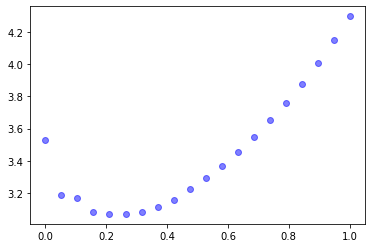

In [111]:
fig, ax = plt.subplots()
ax.scatter(alphas, mse_mean, c='b', alpha=0.5)
plt.show()

In [112]:
alphas[np.argmin(mse_mean)]

0.2113157894736842

### Regardons également la courbe de validation et de train pour vérifier ce résultat

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass param_name=alpha, param_range=[0.001      0.05357895 0.10615789 0.15873684 0.21131579 0.26389474
 0.31647368 0.36905263 0.42163158 0.47421053 0.52678947 0.57936842
 0.63194737 0.68452632 0.73710526 0.78968421 0.84226316 0.89484211
 0.94742105 1.        ] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


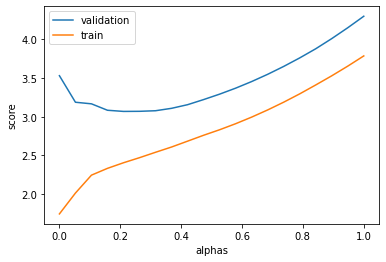

In [119]:
lasso_regressor = Lasso()


train_score, val_score = validation_curve(lasso_regressor, X_scaled, Y,
                                          'alpha', alphas, scoring='neg_mean_squared_error', cv=5)

plt.plot(alphas, -val_score.mean(axis=1), label='validation')
plt.plot(alphas, -train_score.mean(axis=1), label='train')

plt.ylabel('score')
plt.xlabel('alphas')
plt.legend()

## 1.4.1 = Lasso + StandardScaler

3.2525692796741525

In [107]:
mse = list()
alphas = np.linspace(0.001, 1, 50)
for alpha in alphas:
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X_train, Y_train)
    
    y_pred_lasso = lasso_regressor.predict(X_test)
    mse_score_lasso = mean_squared_error(Y_test, y_pred_lasso)
    mse.append(mse_score_lasso)

plt.scatter(alphas, mse)

NameError: name 'X_train' is not defined

In [74]:
## EXERCICE 2

# Exercice 2 : Lors d'essais cliniques, un groupe pharmaceutique souhaite savoir si la
#              concentration d'un produit dans un traitement pour la vue a le meme effet
#              sur deux sous populations. Les resultats d'observations sont regroupes dans
#              le fichier obs2021_2.csv. Dans chacun des groupes, on supposera que le lien
#              entre la concentration du produit et l'efficacite du traitement est lineaire.
#              Definissez et appliquez une methodologie pour tester si l'impact de cette
#              concentration est similaire dans les deux groupes ?

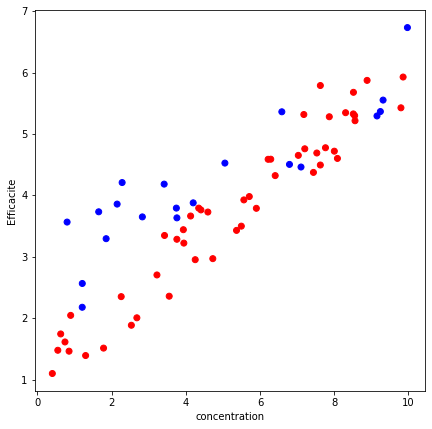

In [5]:

dataframe=pd.read_csv("./obs2021_2.csv",sep=',')

plt.figure(figsize=(7,7))
plt.scatter(dataframe['concentration'], dataframe['Efficacite'], c=['r' if t == 'Groupe_1' else 'b' for t in dataframe['Groupe']])
plt.xlabel("concentration")
plt.ylabel("Efficacite")
plt.show()

In [77]:
dataframe.head()

,Groupe,concentration,Efficacite
0,Groupe_1,3.9479,3.2224
1,Groupe_1,1.7838,1.5127
2,Groupe_1,7.4415,4.3736
3,Groupe_1,8.5625,5.2151
4,Groupe_1,9.8002,5.4256


In [14]:
concentration = dataframe.concentration.values
efficacite = dataframe.Efficacite.values
groups = dataframe.Groupe.values

In [15]:
groups

array(['Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1',
       'Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1',
       'Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1',
       'Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1',
       'Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1',
       'Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1',
       'Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1',
       'Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1',
       'Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1',
       'Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1', 'Groupe_1',
       'Groupe_2', 'Groupe_2', 'Groupe_2', 'Groupe_2', 'Groupe_2',
       'Groupe_2', 'Groupe_2', 'Groupe_2', 'Groupe_2', 'Groupe_2',
       'Groupe_2', 'Groupe_2', 'Groupe_2', 'Groupe_2', 'Groupe_2',
       'Groupe_2', 'Groupe_2', 'Groupe_2', 'Groupe_2', 'Groupe_2'],
      dtype=object)

In [16]:
encoded_groups = np.where(groups == 'Groupe_1', 1, 2)

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
lr = LinearRegression()
lr.fit(concentration.reshape(-1, 1), efficacite)

LinearRegression()

(70,)


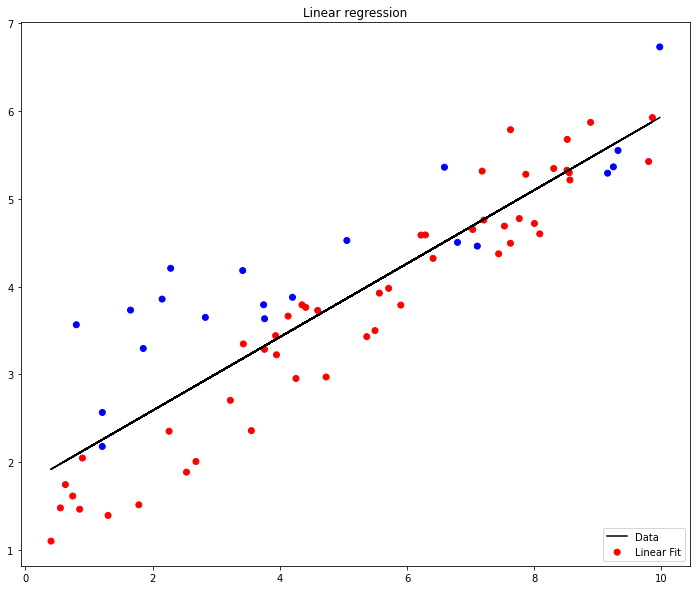

La droite de régression trouvée a pour équation : 0.419x + 1.749
MAE for this model is 0.4457689630119696
MSE for this model is 0.3280917181485785


In [24]:
y_pred = lr.predict(concentration.reshape(-1, 1))
print(y_pred.shape)
fig = plt.figure(figsize=(12, 10))
plt.scatter(concentration, efficacite, c=['r' if encoded_groups[i] == 1 else 'b' for i in range(len(encoded_groups))])
plt.plot(concentration, y_pred, 'k-')
plt.legend(('Data', 'Linear Fit'), loc='lower right')
plt.title('Linear regression')
plt.show()
print(f"La droite de régression trouvée a pour équation : {float(lr.coef_):.3f}x + {float(lr.intercept_):.3f}")
print(f"MAE for this model is {mean_absolute_error(efficacite, y_pred)}")
print(f"MSE for this model is {mean_squared_error(efficacite, y_pred)}")